In [1]:
# Cell 1: Imports and Configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pathlib import Path
import warnings
import sys
import os

# Add current directory to path
sys.path.insert(0, os.getcwd())

from feature_engineering import (
    add_temporal_features,
    add_festival_features,
    add_seasonal_features,
    add_calendarific_features,
    create_lag_features,
    create_rolling_features,
    INDIAN_FESTIVALS,
    fetch_calendarific_holidays
)

warnings.filterwarnings('ignore')

# --- PATH CONFIGURATION ---
BASE_DIR = Path(".").resolve()
DATA_DIR = BASE_DIR / "Data_SIH_2025 2"
ARTIFACT_DIR = Path("artifacts/xgb_models-3.0")
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

# --- API KEY ---
CALENDARIFIC_API_KEY = "Tk4OoTvXa55377qkM2dUSAM5RxMpEb2f"

# --- MODEL CONFIGURATION ---
TARGETS = ['O3_target', 'NO2_target']
LAGS = [1, 2, 3, 6, 12, 24]
ROLLING_WINDOWS = [6, 24]

FORECAST_FEATURES = [
    'O3_forecast', 'NO2_forecast', 'T_forecast', 'q_forecast',
    'u_forecast', 'v_forecast', 'w_forecast'
]

TEMPORAL_FEATURES = [
    'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos',
    'month_sin', 'month_cos', 'doy_sin', 'doy_cos',
    'is_weekend', 'is_rush_hour', 'is_morning_rush', 'is_evening_rush',
    'is_night', 'is_business_hours'
]

FESTIVAL_FEATURES = [
    'is_festival_day', 'festival_impact', 'is_diwali_period', 'is_public_holiday'
]

SEASONAL_FEATURES = [
    'is_winter', 'is_summer', 'is_monsoon', 'is_post_monsoon',
    'is_crop_burning_season', 'is_inversion_likely'
]

XGB_PARAMS = {
    'n_estimators': 1500,
    'learning_rate': 0.03,
    'max_depth': 10,
    'subsample': 0.8,
    'colsample_bytree': 0.7,
    'objective': 'reg:squarederror',
    'n_jobs': -1,
    'early_stopping_rounds': 75,
    'random_state': 42,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
}

print("✅ Configuration Loaded (v3.0 with Calendar Features)")
print(f"📂 Data Directory: {DATA_DIR}")
print(f"📂 Artifacts Directory: {ARTIFACT_DIR}")

✅ Configuration Loaded (v3.0 with Calendar Features)
📂 Data Directory: /Users/pushkalpratapsingh/Downloads/PROJECTSS/untitled folder/PS2-SIH25/ML/Data_SIH_2025 2
📂 Artifacts Directory: artifacts/xgb_models-3.0


In [2]:
# Cell 2: Helper Functions

def R2_SAFE(r2):
    """Clamps R2 to -1.0 to prevent massive negative numbers."""
    return max(r2, -1.0)

def calculate_metrics(y_true, y_pred, site_name, target_name):
    """Calculates comprehensive regression metrics."""
    return {
        'Site': site_name,
        'Target': target_name,
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': R2_SAFE(r2_score(y_true, y_pred)),
        'Bias': np.mean(y_pred - y_true)
    }

def process_site_data(file_path, api_key=None, holidays_cache=None):
    """
    Complete data processing pipeline with all new features.
    """
    df = pd.read_csv(file_path)
    
    # Create datetime
    df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']].astype(int))
    df = df.sort_values('datetime').reset_index(drop=True)
    
    # Interpolate forecast columns
    for col in FORECAST_FEATURES:
        if col in df.columns:
            df[col] = df[col].interpolate(method='linear', limit_direction='both')
    
    # Add temporal features (peak hours, weekends, etc.)
    df = add_temporal_features(df)
    
    # Add festival features (Diwali, etc.)
    df = add_festival_features(df, INDIAN_FESTIVALS)
    
    # Add seasonal features (winter inversion, crop burning, etc.)
    df = add_seasonal_features(df)
    
    # Add Calendarific public holidays
    if holidays_cache:
        df['date_str'] = df['datetime'].dt.strftime('%Y-%m-%d')
        df['is_public_holiday'] = df['date_str'].isin(holidays_cache.keys()).astype(int)
        df = df.drop(columns=['date_str'])
    else:
        df['is_public_holiday'] = 0
    
    # Create lag features
    df = create_lag_features(df, TARGETS, LAGS)
    
    # Create rolling features
    df = create_rolling_features(df, TARGETS, ROLLING_WINDOWS)
    
    return df, holidays_cache

print("✅ Helper Functions Defined")

✅ Helper Functions Defined


In [3]:
# Cell 3: Fetch holidays from Calendarific API

print("🌐 Fetching holidays from Calendarific API...")
print("="*60)

all_holidays = {}
for year in range(2019, 2025):
    holidays = fetch_calendarific_holidays(CALENDARIFIC_API_KEY, "IN", year)
    all_holidays.update(holidays)
    print(f"✅ {year}: {len(holidays)} holidays fetched")

print(f"\n📅 Total holidays cached: {len(all_holidays)}")
print("\nSample holidays:")
for i, (date, name) in enumerate(list(all_holidays.items())[:10]):
    print(f"   {date}: {name}")

🌐 Fetching holidays from Calendarific API...
✅ 2019: 62 holidays fetched
✅ 2020: 63 holidays fetched
✅ 2021: 66 holidays fetched
✅ 2022: 65 holidays fetched
✅ 2023: 67 holidays fetched
✅ 2024: 65 holidays fetched

📅 Total holidays cached: 388

Sample holidays:
   2019-01-01: new_year's_day
   2019-01-13: lohri
   2019-01-15: makar_sankranti
   2019-01-26: republic_day
   2019-02-05: lunar_new_year
   2019-02-09: vasant_panchami
   2019-02-14: valentine's_day
   2019-02-19: guru_ravidas_jayanti
   2019-03-01: maharishi_dayanand_saraswati_jayanti
   2019-03-04: maha_shivaratri/shivaratri


STARTING ENHANCED TRAINING PIPELINE (v3.0 - With Calendar & Temporal Features)

📍 PROCESSING SITE 1
   ------------------------------------------------
   Features: 51 | Train: 20045 | Test: 5012
       > O3_target    | R2: 0.9665 | MAE: 1.98 | RMSE: 5.02
       > NO2_target   | R2: 0.8978 | MAE: 4.49 | RMSE: 8.53


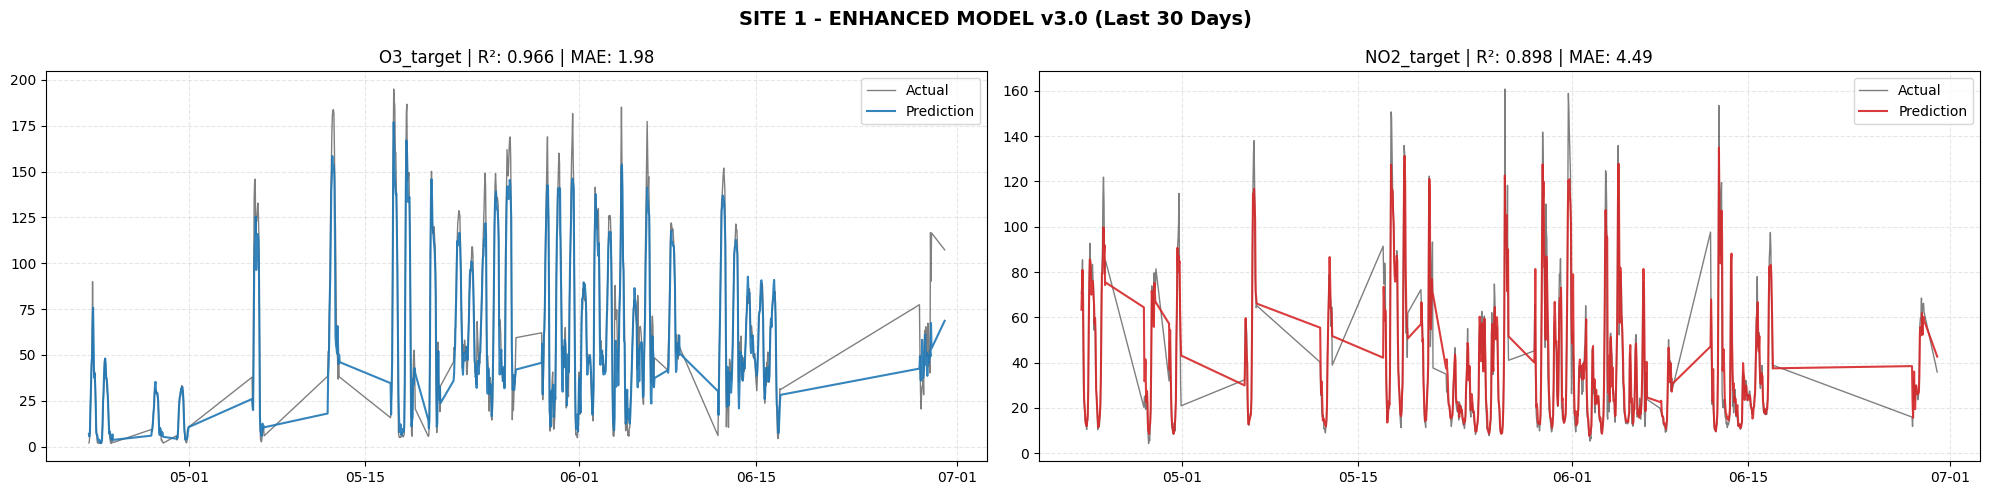


📍 PROCESSING SITE 2
   ------------------------------------------------
   Features: 51 | Train: 20756 | Test: 5189
       > O3_target    | R2: 0.9546 | MAE: 3.09 | RMSE: 5.68
       > NO2_target   | R2: 0.9248 | MAE: 3.68 | RMSE: 6.05


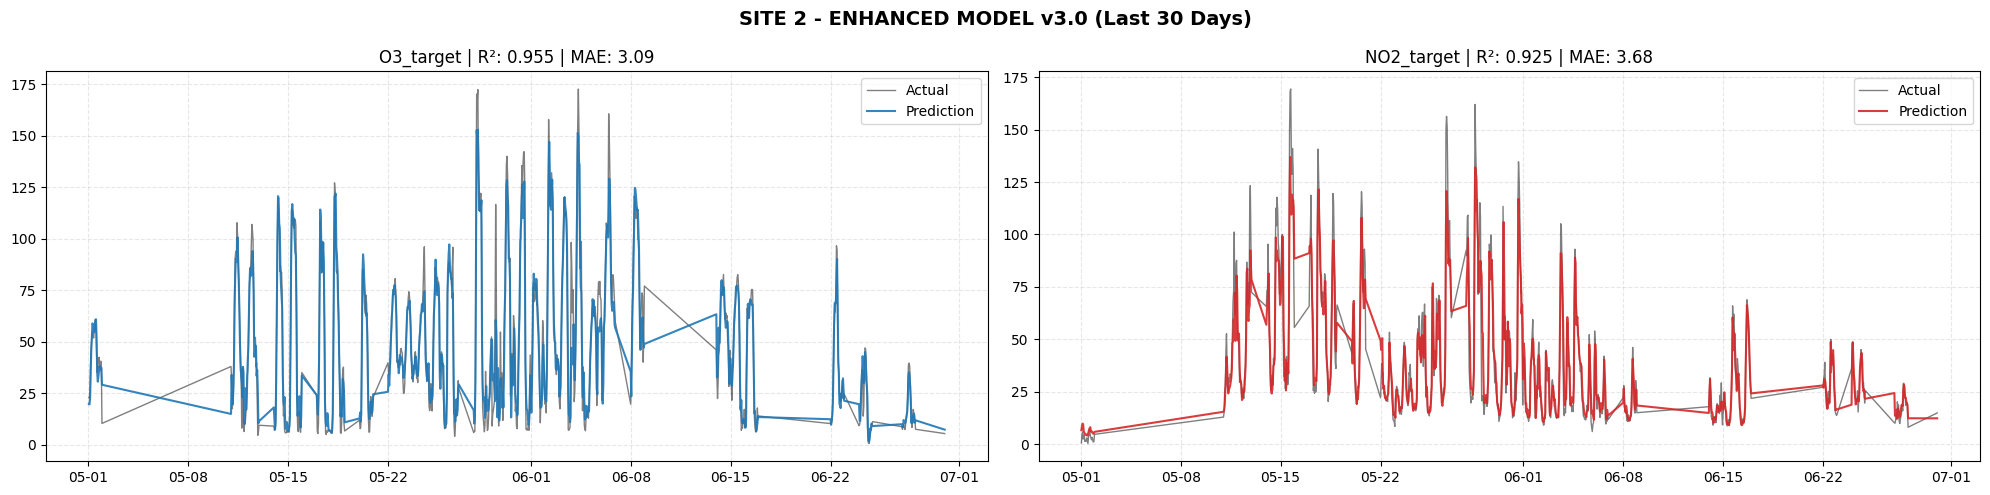


📍 PROCESSING SITE 3
   ------------------------------------------------
   Features: 51 | Train: 17511 | Test: 4378
       > O3_target    | R2: 0.9540 | MAE: 4.95 | RMSE: 8.29
       > NO2_target   | R2: 0.9409 | MAE: 4.69 | RMSE: 7.20


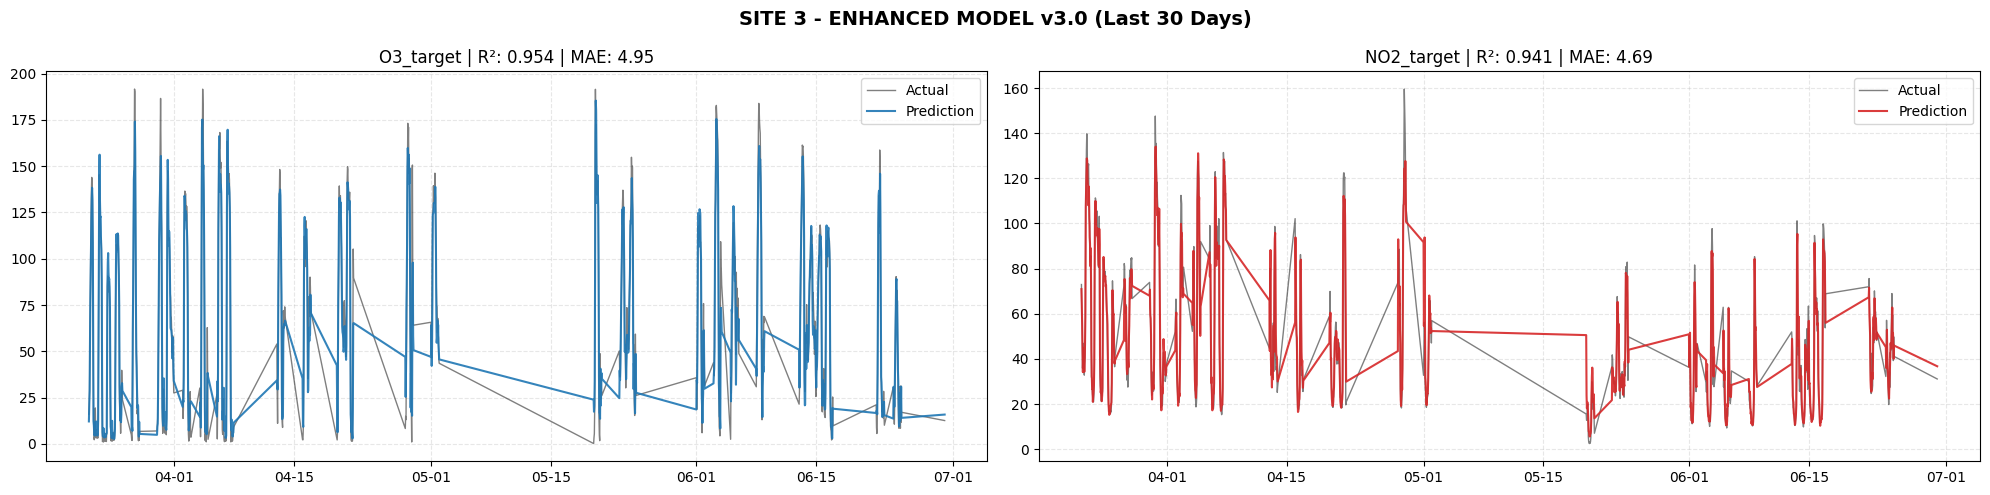


📍 PROCESSING SITE 4
   ------------------------------------------------
   Features: 51 | Train: 19584 | Test: 4897
       > O3_target    | R2: 0.9660 | MAE: 4.13 | RMSE: 6.95
       > NO2_target   | R2: 0.9178 | MAE: 3.46 | RMSE: 5.42


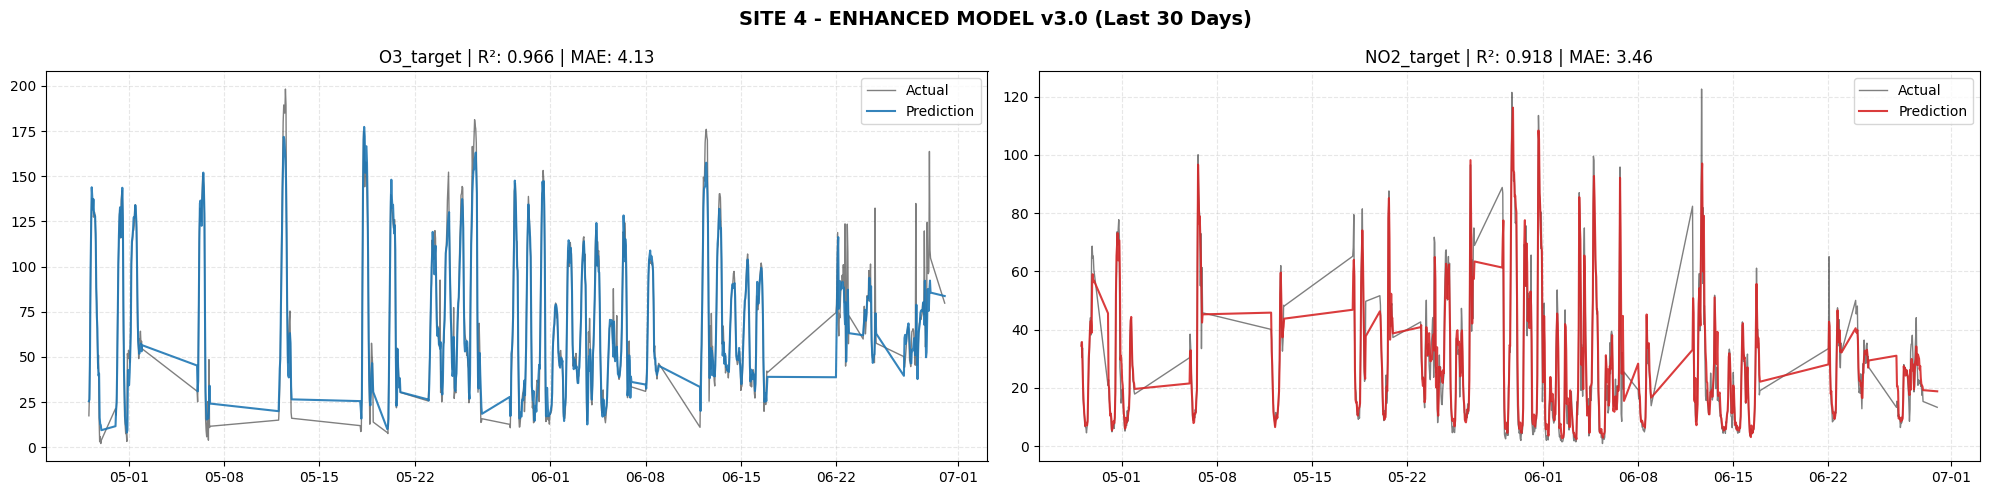


📍 PROCESSING SITE 5
   ------------------------------------------------
   Features: 51 | Train: 20045 | Test: 5012
       > O3_target    | R2: 0.9638 | MAE: 3.85 | RMSE: 6.40
       > NO2_target   | R2: 0.9224 | MAE: 6.25 | RMSE: 11.48


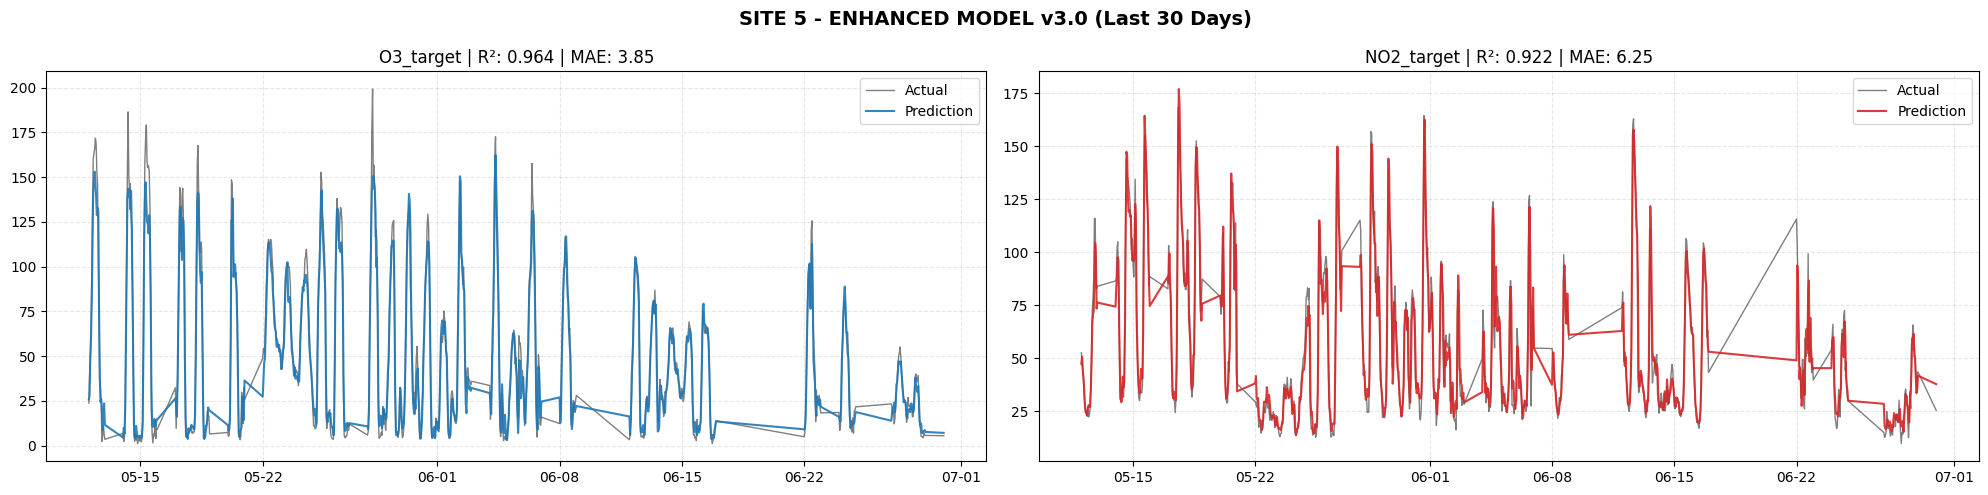


📍 PROCESSING SITE 6
   ------------------------------------------------
   Features: 51 | Train: 21063 | Test: 5266
       > O3_target    | R2: 0.8317 | MAE: 7.06 | RMSE: 15.03
       > NO2_target   | R2: 0.8572 | MAE: 4.51 | RMSE: 8.50


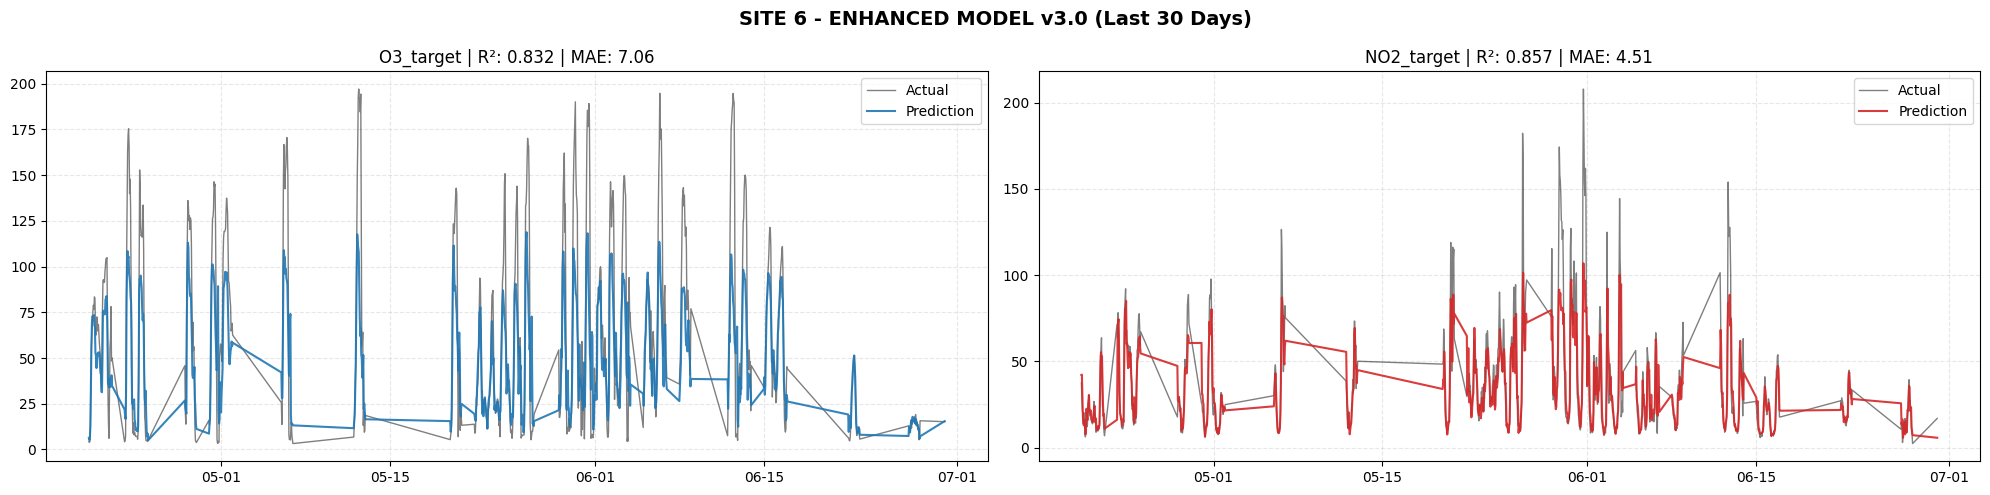


📍 PROCESSING SITE 7
   ------------------------------------------------
   Features: 51 | Train: 18202 | Test: 4551
       > O3_target    | R2: 0.9616 | MAE: 4.16 | RMSE: 6.95
       > NO2_target   | R2: 0.9281 | MAE: 3.10 | RMSE: 5.34


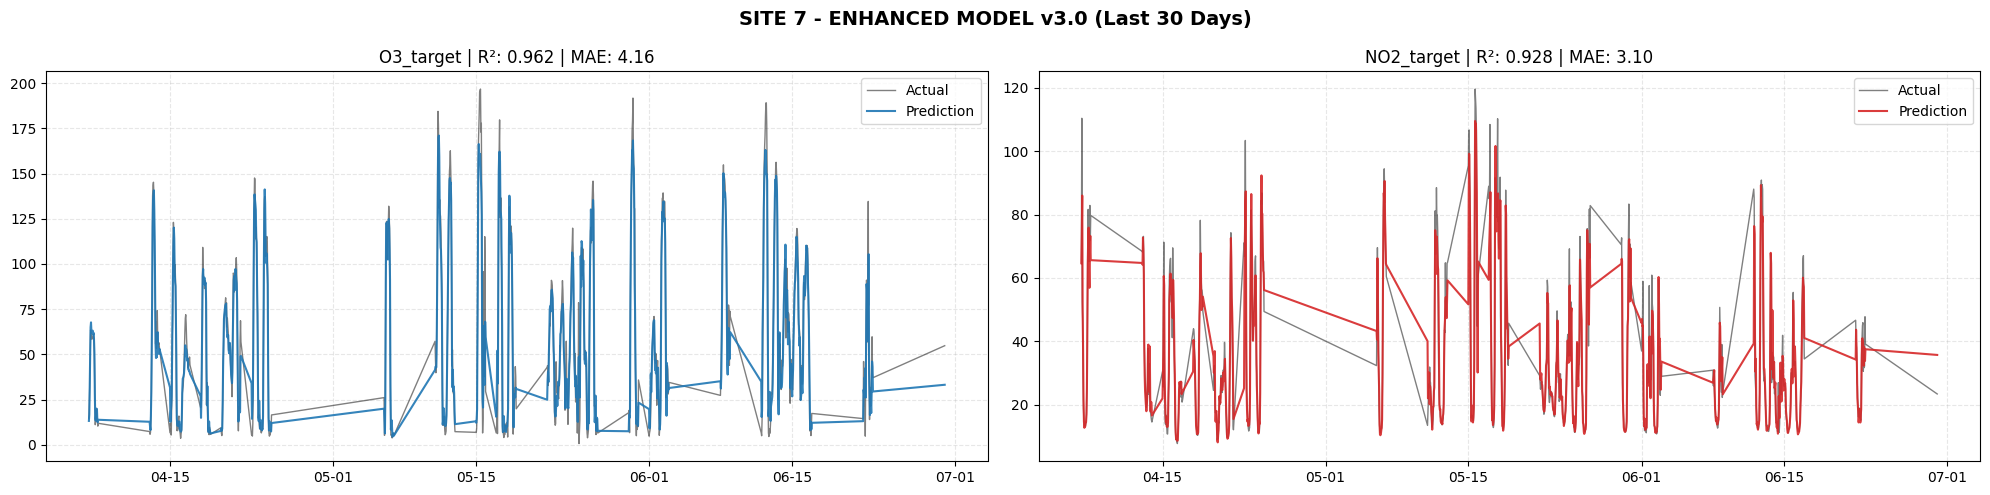

In [4]:
# Cell 4: Training Pipeline

all_metrics = []
feature_importance_all = {}

print(f"{'='*100}")
print("STARTING ENHANCED TRAINING PIPELINE (v3.0 - With Calendar & Temporal Features)")
print(f"{'='*100}\n")

for site_id in range(1, 8):
    file_path = DATA_DIR / f"site_{site_id}_train_data.csv"
    if not file_path.exists():
        print(f"⚠️ Skipping Site {site_id} (File not found)")
        continue
    
    print(f"📍 PROCESSING SITE {site_id}")
    print(f"   ------------------------------------------------")
    
    # Process data with all new features
    df_processed, _ = process_site_data(file_path, holidays_cache=all_holidays)
    
    # Build feature list
    lag_features = [col for col in df_processed.columns if 'lag' in col]
    rolling_features = [col for col in df_processed.columns if 'rolling' in col]
    
    all_features = (
        FORECAST_FEATURES +
        TEMPORAL_FEATURES +
        FESTIVAL_FEATURES +
        SEASONAL_FEATURES +
        lag_features +
        rolling_features
    )
    
    # Filter to existing columns
    feature_cols = [f for f in all_features if f in df_processed.columns]
    
    # Drop NaN rows for required columns
    cols_to_check = TARGETS + feature_cols
    df_processed = df_processed.dropna(subset=cols_to_check).reset_index(drop=True)
    
    # Train/Test split (80/20)
    train_size = int(len(df_processed) * 0.80)
    train_df = df_processed.iloc[:train_size]
    test_df = df_processed.iloc[train_size:]
    
    print(f"   Features: {len(feature_cols)} | Train: {len(train_df)} | Test: {len(test_df)}")
    
    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    fig.suptitle(f"SITE {site_id} - ENHANCED MODEL v3.0 (Last 30 Days)", fontsize=14, fontweight='bold')
    
    for idx, target in enumerate(TARGETS):
        # Train model
        model = xgb.XGBRegressor(**XGB_PARAMS)
        model.fit(
            train_df[feature_cols], train_df[target],
            eval_set=[(test_df[feature_cols], test_df[target])],
            verbose=False
        )
        
        # Predict
        y_pred = model.predict(test_df[feature_cols])
        
        # Metrics
        m = calculate_metrics(test_df[target], y_pred, f"site_{site_id}", target)
        all_metrics.append(m)
        print(f"       > {target:<12} | R2: {m['R2']:.4f} | MAE: {m['MAE']:.2f} | RMSE: {m['RMSE']:.2f}")
        
        # Save model
        model.save_model(ARTIFACT_DIR / f"site_{site_id}_{target}_xgb.json")
        
        # Store feature importance
        importance = pd.Series(
            model.feature_importances_,
            index=feature_cols
        ).sort_values(ascending=False)
        feature_importance_all[f"site_{site_id}_{target}"] = importance
        
        # Plot (last 30 days = 720 hours)
        ax = axes[idx]
        zoom_hours = 720
        if len(test_df) > zoom_hours:
            plot_dates = test_df['datetime'].iloc[-zoom_hours:]
            plot_true = test_df[target].iloc[-zoom_hours:]
            plot_pred = y_pred[-zoom_hours:]
        else:
            plot_dates = test_df['datetime']
            plot_true = test_df[target]
            plot_pred = y_pred
        
        ax.plot(plot_dates, plot_true, color='black', alpha=0.5,
                label='Actual', linewidth=1)
        color = '#d62728' if 'NO2' in target else '#1f77b4'
        ax.plot(plot_dates, plot_pred, color=color, alpha=0.9,
                label='Prediction', linewidth=1.5)
        
        ax.set_title(f"{target} | R²: {m['R2']:.3f} | MAE: {m['MAE']:.2f}")
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax.legend(loc='upper right')
        ax.grid(alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.savefig(ARTIFACT_DIR / f"site_{site_id}_predictions.png", dpi=150, bbox_inches='tight')
    plt.show()
    print()

FEATURE IMPORTANCE ANALYSIS

TOP 25 MOST IMPORTANT FEATURES (Averaged across all sites/targets):

NO2_target_lag_1             0.219616
O3_target_lag_1              0.208769
O3_target_lag_24             0.077184
NO2_target_rolling_mean_6    0.060234
hour_sin                     0.045385
is_morning_rush              0.037210
is_rush_hour                 0.037023
NO2_target_lag_2             0.029542
O3_target_rolling_mean_6     0.027693
O3_target_lag_2              0.027642
NO2_target_rolling_std_6     0.025226
O3_target_rolling_std_6      0.019562
NO2_target_lag_24            0.018444
hour_cos                     0.014930
NO2_target_lag_3             0.011307
O3_target_rolling_std_24     0.009459
is_night                     0.008729
O3_target_lag_6              0.008526
O3_target_lag_3              0.007997
is_evening_rush              0.007430
is_winter                    0.006939
NO2_target_lag_6             0.006814
is_monsoon                   0.006404
festival_impact             

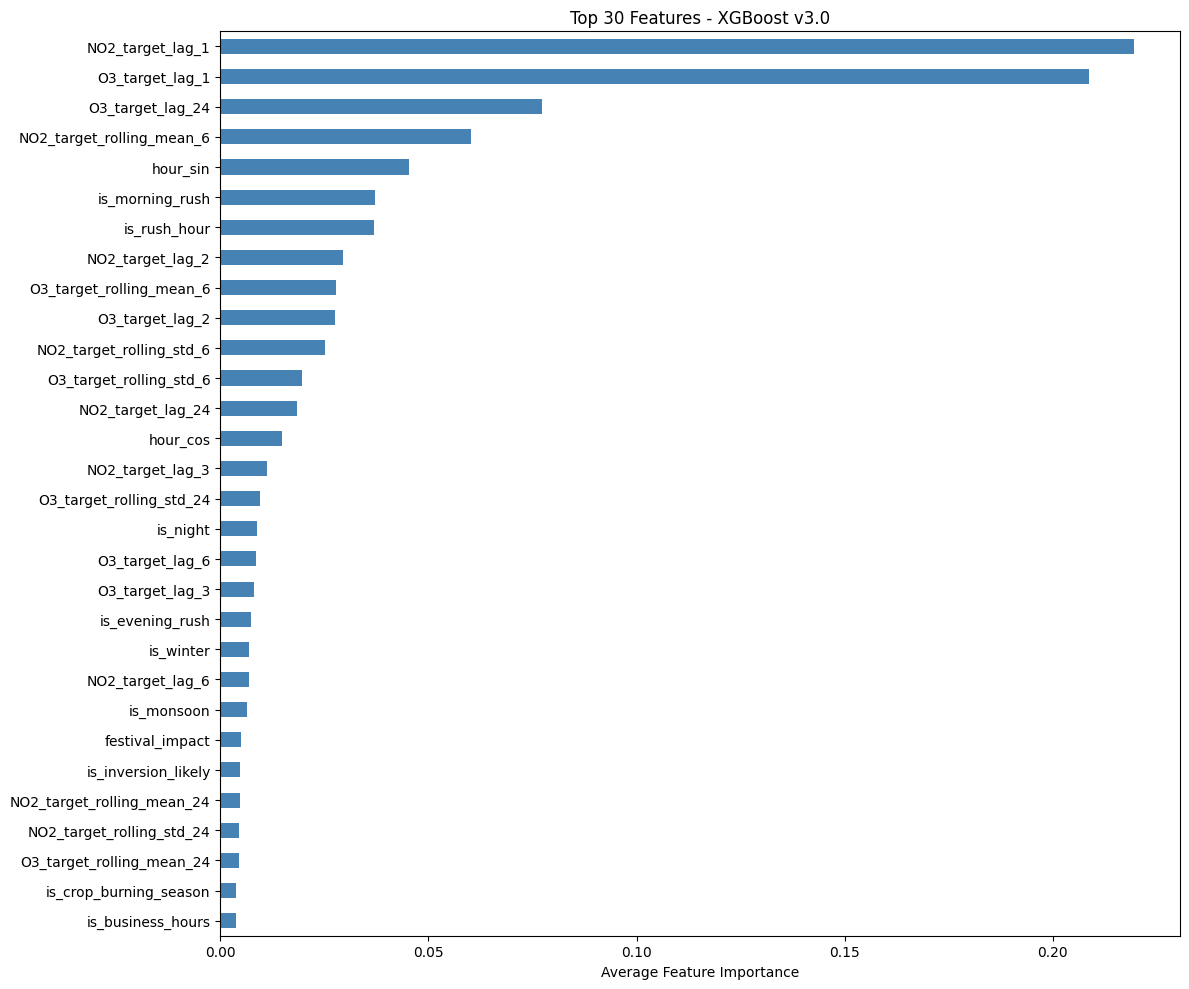


NEW CALENDAR/TEMPORAL FEATURES IMPORTANCE:

hour_sin                  0.045385
is_morning_rush           0.037210
is_rush_hour              0.037023
hour_cos                  0.014930
is_night                  0.008729
is_evening_rush           0.007430
is_winter                 0.006939
is_monsoon                0.006404
festival_impact           0.004885
is_inversion_likely       0.004652
is_crop_burning_season    0.003710
is_business_hours         0.003699
doy_cos                   0.003649
is_post_monsoon           0.003539
is_diwali_period          0.003519
is_summer                 0.003453
month_cos                 0.003247
is_festival_day           0.003004
doy_sin                   0.002947
month_sin                 0.002854
is_public_holiday         0.001678
is_weekend                0.001555
dow_sin                   0.001482
dow_cos                   0.001418


In [5]:
# Cell 5: Feature Importance Analysis

print(f"{'='*80}")
print("FEATURE IMPORTANCE ANALYSIS")
print(f"{'='*80}\n")

# Aggregate importance across all sites
importance_df = pd.DataFrame(feature_importance_all)
all_importance = importance_df.mean(axis=1).sort_values(ascending=False)

print("TOP 25 MOST IMPORTANT FEATURES (Averaged across all sites/targets):\n")
print(all_importance.head(25).to_string())

# Visualize
fig, ax = plt.subplots(figsize=(12, 10))
all_importance.head(30).plot(kind='barh', ax=ax, color='steelblue')
ax.set_xlabel('Average Feature Importance')
ax.set_title('Top 30 Features - XGBoost v3.0')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig(ARTIFACT_DIR / 'feature_importance.png', dpi=150)
plt.show()

# Check NEW features importance
print("\n" + "="*80)
print("NEW CALENDAR/TEMPORAL FEATURES IMPORTANCE:")
print("="*80 + "\n")

new_features = TEMPORAL_FEATURES + FESTIVAL_FEATURES + SEASONAL_FEATURES
new_feature_importance = all_importance[all_importance.index.isin(new_features)]
print(new_feature_importance.sort_values(ascending=False).to_string())

In [6]:
# Cell 6: Final Summary & Comparison

results_df = pd.DataFrame(all_metrics)

print(f"{'='*80}")
print("FINAL SUMMARY - XGBoost v3.0 (With Calendar & Temporal Features)")
print(f"{'='*80}")
print(results_df.round(4).to_string(index=False))

print(f"\n{'='*80}")
print("AVERAGE METRICS ACROSS ALL 7 SITES")
print(f"{'='*80}")
avg_metrics = results_df.groupby('Target')[['R2', 'MAE', 'RMSE', 'Bias']].mean()
print(avg_metrics.round(4).to_string())

# Save reports
results_df.to_csv(ARTIFACT_DIR / "final_metrics_report_v3.csv", index=False)
avg_metrics.to_csv(ARTIFACT_DIR / "average_metrics_summary_v3.csv")

print(f"\n📄 All artifacts saved to: {ARTIFACT_DIR}")

# Compare with v2.0 if available
v2_path = Path("artifacts/xgb_models-2.0/average_metrics_summary.csv")
if v2_path.exists():
    print(f"\n{'='*80}")
    print("COMPARISON WITH v2.0")
    print(f"{'='*80}")
    v2_avg = pd.read_csv(v2_path)
    print("\nv2.0 Average Metrics:")
    print(v2_avg.round(4).to_string(index=False))
    print("\nv3.0 Average Metrics:")
    print(avg_metrics.reset_index().round(4).to_string(index=False))

FINAL SUMMARY - XGBoost v3.0 (With Calendar & Temporal Features)
  Site     Target    MAE    RMSE     R2    Bias
site_1  O3_target 1.9812  5.0174 0.9665 -0.3139
site_1 NO2_target 4.4933  8.5348 0.8978 -0.5720
site_2  O3_target 3.0935  5.6783 0.9546  0.1624
site_2 NO2_target 3.6804  6.0515 0.9248 -0.1141
site_3  O3_target 4.9480  8.2886 0.9540 -0.0914
site_3 NO2_target 4.6881  7.2000 0.9409  0.6835
site_4  O3_target 4.1340  6.9471 0.9660 -0.4667
site_4 NO2_target 3.4612  5.4155 0.9178  0.2837
site_5  O3_target 3.8518  6.3976 0.9638 -0.6304
site_5 NO2_target 6.2452 11.4756 0.9224 -0.7312
site_6  O3_target 7.0635 15.0253 0.8317 -2.5629
site_6 NO2_target 4.5124  8.5028 0.8572 -1.0715
site_7  O3_target 4.1572  6.9473 0.9616  0.0413
site_7 NO2_target 3.1020  5.3359 0.9281 -0.2335

AVERAGE METRICS ACROSS ALL 7 SITES
                R2     MAE    RMSE    Bias
Target                                    
NO2_target  0.9127  4.3118  7.5023 -0.2507
O3_target   0.9426  4.1756  7.7574 -0.5517

📄 All 